In [1]:
from maelstrom.orbit import Orbit
import numpy as np
import exoplanet as xo
from maelstrom import Maelstrom
import matplotlib.pyplot as plt

In [2]:
time, flux = np.loadtxt('data/kic9651065_lc.txt', usecols=(0,1)).T

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1081ca5c0>,
      dtype=object)

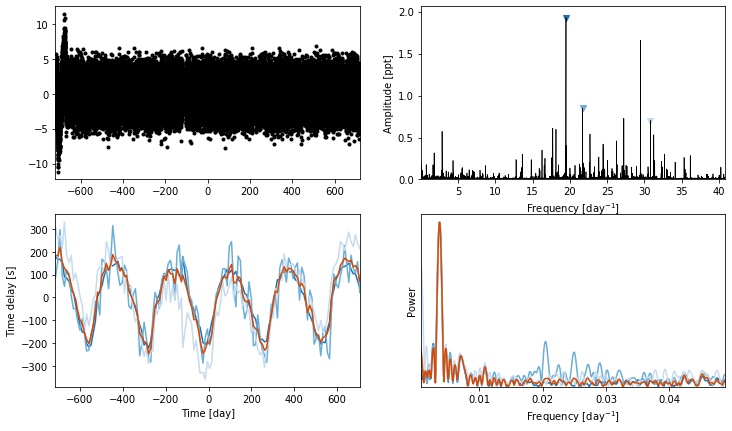

In [3]:
ms = Maelstrom(time, flux, max_peaks=3, fmax=48)
ms.first_look()

In [4]:
time, flux, freq = ms.time, ms.flux, ms.freq
amp = ms.get_weights(norm=False)

In [10]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    period = pm.Normal("period", mu=272, sd=1)
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(184), sd=100, testval=np.log(184))
    asini = pm.Deterministic("asini", pm.math.exp(logasini))
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", pm.math.exp(lognu))
    logamp = pm.Normal("logamp", mu=amp, sd=1.0, shape=len(freq),testval=amp)
    
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=freq, 
                  amp=pm.math.exp(logamp))
    
    lc = orbit.get_lightcurve_model(time)# + mean
    kernel = orbit.get_gp_kernel(time)
    
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    pm.Potential('obs', gp.log_likelihood(flux - lc))

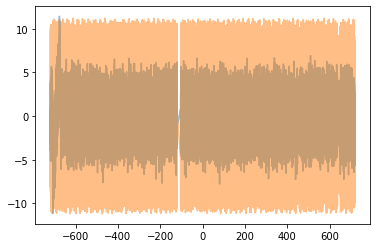

In [11]:
with model:
    plt.plot(time, flux, alpha=0.5)
    plt.plot(time, xo.eval_in_model(lc), alpha=0.5)

In [12]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    #map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    #map_params = xo.optimize(start=map_params, vars=[orbit.phase, orbit.logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    #map_params = xo.optimize(start=map_params, vars=[orbit.lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, flux, alpha=0.5)

[period, phi_angle__, logs_lc, logasini, omega_angle__, eccen_interval__, mean, lognu, logamp, phase_angle__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -1304861.1621637538 -> -1304861.1621637132
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -1304861.1621637132 -> -232267.606614823
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -232267.606614823 -> -229050.2501834155
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -229050.2501834155 -> -229010.54786813163
optimizing logp for variables: ['logpower', 'logw0_interval__', 'phase_angle__', 'logamp', 'lognu', 'mean', 'eccen_interval__', 'omega_angle__', 'logasini', 'logs_lc', 'phi_angle__', 'period']
message: Desired error not necessarily achieved due to precision loss.
logp: -229010.5478681

NameError: name 'logP' is not defined

In [13]:
map_params

{'period': array(271.7901106),
 'phi_angle__': array([0.20825643, 4.46728543]),
 'logs_lc': array(0.24034613),
 'logasini': array(5.21373563),
 'omega_angle__': array([-3.57250855,  2.69019925]),
 'eccen_interval__': array(0.00345577),
 'mean': array(-9.46000122e-05),
 'lognu': array([2.9692689 , 3.07787128, 3.42757628]),
 'logamp': array([ 0.66999645, -0.14160306, -0.31524392]),
 'phase_angle__': array([[-3.72804216, -0.36560217,  3.34173258],
        [-2.47016288, -4.45715974, -2.97199656]]),
 'logw0_interval__': array(-0.38299813),
 'logpower': array(-3.22030396),
 'phi': array(0.04658439),
 'asini': array(183.77930987),
 'omega': array(-0.92536006),
 'eccen': array(0.45077755),
 'nu': array([19.47767426, 21.71213419, 30.80189706]),
 'phase': array([-2.1559712 , -3.05975006,  2.29770065]),
 'logw0': array(-0.90033876),
 'logS0': array(0.38105107)}

In [9]:
freq

array([19.47767426, 21.71213419, 30.80189706])

In [30]:
ecosw = np.linspace(0,np.pi/5,1000)
esinw = np.linspace(0,np.pi/4,1000)
X, Y = np.meshgrid(ecosw, esinw)
e = np.sqrt(X**2 + Y**2)

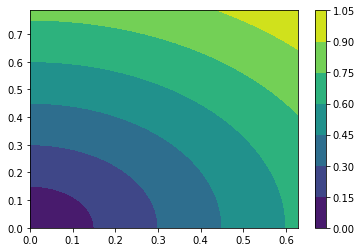

In [31]:
plt.contourf(X, Y, e)
plt.colorbar()
#plt.xticks([0, np.pi/4, np.pi/2])